<a href="https://colab.research.google.com/github/Maksym-Ivanov/drones_img_recognition/blob/res_branch/drones_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ноутбук виконувався на Google Colab з обмеженням 15гб GPU

# Imports

In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [ ]:
!cp "/content/drive/MyDrive/drones/dataset.zip" -d "/content/dataset.zip"

In [ ]:
!unzip '/content/dataset.zip'

#Visualization

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

In [ ]:
def img_pair_visualization(path1, path2):
    image1 = Image.open(path1)
    image2 = Image.open(path2)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image1)
    axes[0].set_title('Satelite')
    axes[1].imshow(image2)
    axes[1].set_title('UAV')

    plt.show()

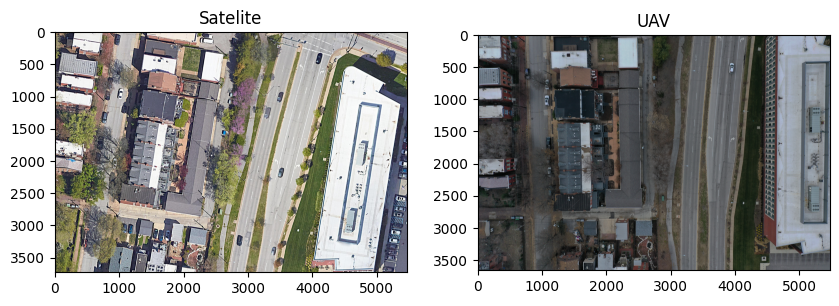

In [ ]:
img1 = '/content/dataset/RGB/sat_images/DJI_0272.JPG'
img_pair_visualization(img1, os.path.join('/content/dataset/RGB/uav_images', os.path.basename(img1)))

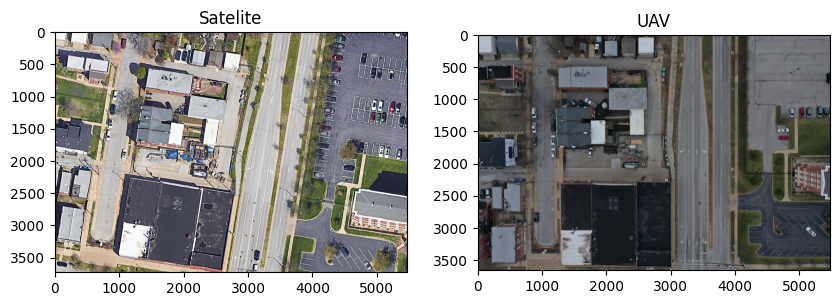

In [ ]:
img1 = '/content/dataset/RGB/sat_images/DJI_0283.JPG'
img_pair_visualization(img1, os.path.join('/content/dataset/RGB/uav_images', os.path.basename(img1)))

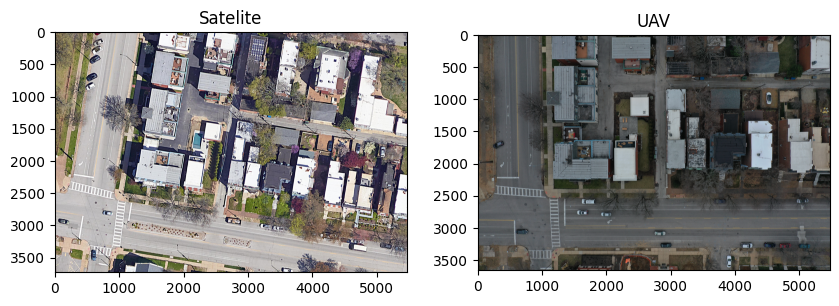

In [ ]:
img1 = '/content/dataset/RGB/sat_images/DJI_0586.JPG'
img_pair_visualization(img1, os.path.join('/content/dataset/RGB/uav_images', os.path.basename(img1)))

Особливості данних:
1. Ротейшн. Модель має це підтримувати
2. Різний контраст та кольори
3. Немає видимого викривлення. Чого немає у дронів?
4. Єдине що ніколи не змінюється - розташування дорог та будівель. Можна спробувати порівнювати контури

# Model Selection


## Contours Compare
Я вирішив спробувати перевірити підхід з порівнянням контурів, бо це найпростіший спосіб та не треба витрачати час на навчання моделі

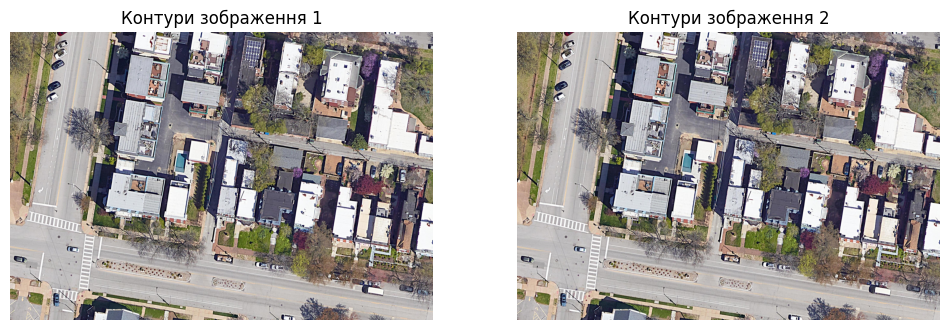

Відповідність контурів: 0.0


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Зчитування зображень
image1 = cv2.imread('/content/dataset/RGB/sat_images/DJI_0586.JPG')
#image2 = cv2.imread(os.path.join('/content/dataset/RGB/uav_images', os.path.basename(img1)))
image2 = image1

# Конвертація в чорно-біле та бінаризація
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
_, thresh1 = cv2.threshold(gray1, 50, 255, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(gray2, 50, 255, cv2.THRESH_BINARY)

# Знаходження контурів
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Порівняння контурів
match = cv2.matchShapes(contours1[0], contours2[0], cv2.CONTOURS_MATCH_I1, 0.0)

# Виведення контурів
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title("Контури зображення 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title("Контури зображення 2")
plt.axis('off')

plt.show()

# Виведення результату
print("Відповідність контурів:", match)

In [ ]:
import cv2

def show_image_with_contours(image_path):
    # Зчитування зображення
    image = cv2.imread(image_path)

    # Конвертація в чорно-біле та бінаризація
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Знаходження контурів
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Відмальовування контурів на зображенні
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title('Image with Contours')
    plt.axis('off')
    plt.show()

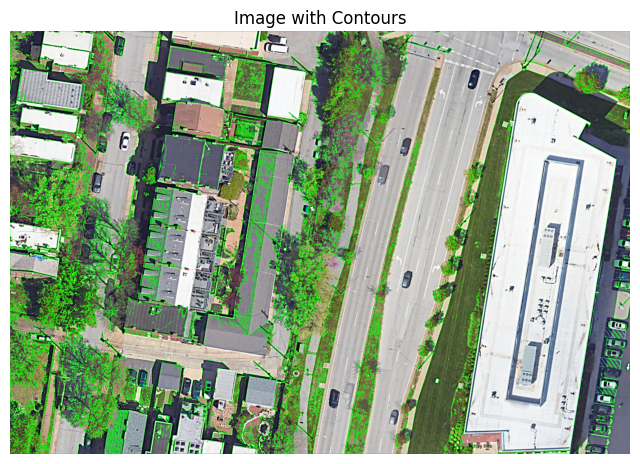

In [ ]:
img1 = '/content/dataset/RGB/sat_images/DJI_0272.JPG'
show_image_with_contours(img1)

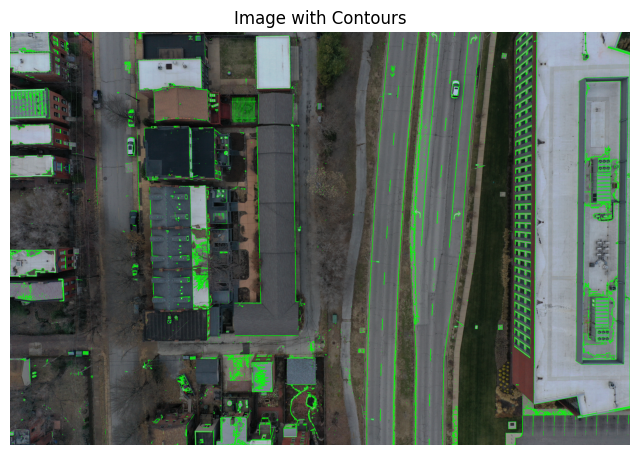

In [ ]:
img1 = '/content/dataset/RGB/uav_images/DJI_0272.JPG'
show_image_with_contours(img1)

In [ ]:
path1 = '/content/dataset/RGB/sat_images/DJI_0286.JPG'
path2 = '/content/dataset/RGB/uav_images/DJI_0286.JPG'

In [ ]:
import cv2
import numpy as np

def normalize_contour(contour, image_shape):
    x, y, w, h = cv2.boundingRect(contour)

    moments = cv2.moments(contour)
    angle = 0.5 * np.arctan2(2 * moments['mu11'], moments['mu20'] - moments['mu02'])
    rotation_matrix = cv2.getRotationMatrix2D((x + w / 2, y + h / 2), np.degrees(angle), 1)

    assert rotation_matrix is not None, "Failed to compute rotation matrix"

    rotation_matrix[0, 2] += w / 2 - (x + w / 2)
    rotation_matrix[1, 2] += h / 2 - (y + h / 2)

    contour = cv2.warpAffine(np.uint8(np.ones(image_shape)), rotation_matrix, (image_shape[1], image_shape[0]), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    area = cv2.contourArea(contour)
    target_area = 100.0
    scale = (target_area / area) ** 0.5
    contour = cv2.resize(contour, None, fx=scale, fy=scale)

    return contour

image1 = cv2.imread(path1)
image2 = cv2.imread(path2)

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

_, thresh1 = cv2.threshold(gray1, 127, 255, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(gray2, 127, 255, cv2.THRESH_BINARY)

contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_shape = gray1.shape[::-1]

normalized_contours1 = [normalize_contour(contour, image_shape) for contour in contours1]
normalized_contours2 = [normalize_contour(contour, image_shape) for contour in contours2]

match = cv2.matchShapes(normalized_contours1[0], normalized_contours2[0], cv2.CONTOURS_MATCH_I1, 0.0)
print("Відповідність контурів після нормалізації:", match)


In [ ]:
import cv2

image1 = cv2.imread(path1)
image2 = cv2.imread(path2)

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
_, thresh1 = cv2.threshold(gray1, 127, 255, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(gray2, 127, 255, cv2.THRESH_BINARY)

contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Порівняння кожного контуру на першому зображенні з кожним контуром на другому зображенні
img_match = list()
for contour1 in contours1:
    matches = list()
    for contour2 in contours2:
        # Порівняння контурів
        match = cv2.matchShapes(contour1, contour2, cv2.CONTOURS_MATCH_I1, 0.0)
        matches.append(match)
        #print("Відповідність контурів:", match)
    img_match.append(max(matches))
print(sum(img_match) / len(img_match))

###Висновок на порівняння контурів
Потенційно найкращий шлях це зробити це порівнювати кожен контур (кожен ланцюг) першого зображення з кожним іншим на другому. Це виявилось дуже складною операцією (M*N) для кількості контурів яку я зміг отримати. Час на порівняння однієї пари близько 4хв (соромно навіть казати).

А це навіть без врахування нормалізації зображень(контурів), адже порівняння працює тільки в одному масштабі та орієнтації зображень

Тому метод (в моїй реалізації) себе не виправдав взагалі

# TripletNet

Знайшов цю модель і виділив серед інших, бо вона приймає не пару зображень для навчання, а одразу три: пара зображень що відповідає одінй сцені та одне випадкове інше - неправильне. Такий підхід, на мою думку має потенційно краще працювати з цими складними даними та ефективніше навчатись на обмеженому наборі даних. Бо модель має балансувати "відстані" між парою зображень однієї сцени та випадкових.

Знайшов готову реалізацію коду для навчання, щоб не витрачати час. Довелось дописати деякі необхідні методи. Код не був повний

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import torch.nn.functional as F
import random
import shutil

In [ ]:
test_dir = '/content/test_dir'
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

test_sat_images = os.path.join(test_dir, 'sat_images')
if not os.path.exists(test_sat_images):
    os.mkdir(test_sat_images)

test_uav_images = os.path.join(test_dir, 'uav_images')
if not os.path.exists(test_uav_images):
    os.mkdir(test_uav_images)

test_fasle_sat_images = os.path.join(test_dir, 'false_sat_images')
if not os.path.exists(test_fasle_sat_images):
    os.mkdir(test_fasle_sat_images)

In [ ]:
## NOT to do
import shutil

#shutil.rmtree('/content/test_dir')

In [ ]:
uav_dir = '/content/dataset/RGB/uav_images'
sat_dir = '/content/dataset/RGB/sat_images'
test_imgs_len = int(len(os.listdir(uav_dir)) * 0.3)

false_sat_dir = '/content/dataset/RGB/false_sat_images'

for img_name in random.sample(os.listdir(uav_dir), test_imgs_len):
    uav_path = os.path.join(uav_dir, img_name)
    sat_path = os.path.join(sat_dir, img_name)

    shutil.move(uav_path, test_uav_images)
    shutil.move(sat_path, test_sat_images)

    false_sat_images = os.listdir(false_sat_dir)
    rand_false_sat_img = random.choice(false_sat_images)
    rand_false_sat_path = os.path.join(false_sat_dir, rand_false_sat_img)
    shutil.move(rand_false_sat_path, test_fasle_sat_images)


In [ ]:
print(f"Test false_sat_img: {len(os.listdir(test_fasle_sat_images))}")
print(f"Test sat_img: {len(os.listdir(test_sat_images))}")
print(f"Test uav_img: {len(os.listdir(test_uav_images))}")

Test false_sat_img: 127
Test sat_img: 127
Test uav_img: 127


In [ ]:
class TripletSatUavDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.sat_images = os.listdir(os.path.join(root_dir, 'sat_images'))
        self.uav_images = os.listdir(os.path.join(root_dir, 'uav_images'))
        self.false_sat_images = os.listdir(os.path.join(root_dir, 'false_sat_images'))

    def __len__(self):
        return min(len(self.sat_images), len(self.uav_images), len(self.false_sat_images))

    def __getitem__(self, idx):
        random_uav_img_name = random.choice(self.uav_images)
        corresponding_sat_img_name = random_uav_img_name.replace('.jpg', '.png')
        corresponding_sat_img_path = os.path.join(self.root_dir, 'sat_images', corresponding_sat_img_name)
        uav_img_path = os.path.join(self.root_dir, 'uav_images', random_uav_img_name)

        random_false_sat_img_name = random.choice(self.false_sat_images)
        false_sat_img_path = os.path.join(self.root_dir, 'false_sat_images', random_false_sat_img_name)

        uav_img = Image.open(uav_img_path)
        corresponding_sat_img = Image.open(corresponding_sat_img_path)
        false_sat_img = Image.open(false_sat_img_path)

        if self.transform:
            uav_img = self.transform(uav_img)
            corresponding_sat_img = self.transform(corresponding_sat_img)
            false_sat_img = self.transform(false_sat_img)

        return uav_img, corresponding_sat_img, false_sat_img

In [ ]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc = nn.Linear(256*28*28, 256)  # Check if the dimension matches your image size

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.nn.functional.pairwise_distance(anchor, positive)
        distance_negative = torch.nn.functional.pairwise_distance(anchor, negative)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(loss)

In [ ]:
def save_train_batch_images(train_batch, save_dir):
    # Створіть каталог для збереження зображень, якщо він не існує
    os.makedirs(save_dir, exist_ok=True)

    # Збереження зображень з train_batch
    for i, (anchor, positive, negative) in enumerate(train_batch):
        save_image(anchor, os.path.join(save_dir, f'anchor_{i}.png'))
        save_image(positive, os.path.join(save_dir, f'positive_{i}.png'))
        save_image(negative, os.path.join(save_dir, f'negative_{i}.png'))

In [ ]:
def train(model, criterion, optimizer, dataloader, num_epochs, save_dir):
    best_loss = float('inf')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        train_batches = list()
        for i, data in enumerate(dataloader, 0):
            anchor, positive, negative = data
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            train_batches.append((anchor, positive, negative))

            optimizer.zero_grad()
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)
            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Збереження train_batch
            #save_train_batch_images(train_batches, '/content/batches')


        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}')

        # Save the model if the loss is the best so far
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_weights.pth'))

        # Save the model at the end of each epoch
        torch.save(model.state_dict(), os.path.join(save_dir, 'last_weights.pth'))

    print('Finished Training')

In [ ]:
def predict(model, img_path1, img_path2, image_size=(224, 224)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        # Завантаження та перетворення зображень у тензори
        # transform = transforms.Compose([
        #     transforms.Resize(image_size),
        #     transforms.ToTensor()
        # ])

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        img1 = transform(Image.open(img_path1)).unsqueeze(0).to(device)
        img2 = transform(Image.open(img_path2)).unsqueeze(0).to(device)

        embedding1 = model(img1)
        embedding2 = model(img2)

    distance = torch.nn.functional.pairwise_distance(embedding1, embedding2)

    # Нормалізація відстані до діапазону [0, 1] за допомогою сигмоїди
    similarity = torch.sigmoid(-distance)  # Використання від'ємної відстані для отримання більш високого значення для більш схожих зображень
    #print(similarity.item())
    return similarity.item(), distance.item()
    #return distance.item()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = TripletSatUavDataset(root_dir='/content/dataset/RGB', transform=transform)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

model = TripletNet()
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, criterion, optimizer, dataloader, num_epochs=150, save_dir='/content/drive/MyDrive/drones/weigths/2')


Epoch [1/150], Loss: 6.405923742997019
Epoch [2/150], Loss: 1.563340293733697
Epoch [3/150], Loss: 0.34471737711053146
Epoch [4/150], Loss: 2.3440651642648795
Epoch [5/150], Loss: 4.5087585951152604
Epoch [6/150], Loss: 4.536786932694285
Epoch [7/150], Loss: 0.1729620381405479
Epoch [8/150], Loss: 0.36894996542679637
Epoch [9/150], Loss: 0.047125816345214844
Epoch [10/150], Loss: 0.049312440972579155
Epoch [11/150], Loss: 0.0
Epoch [12/150], Loss: 0.09642247149818822
Epoch [13/150], Loss: 0.06902679644132916
Epoch [14/150], Loss: 0.0073871612548828125
Epoch [15/150], Loss: 0.170429832056949
Epoch [16/150], Loss: 0.2478296631260922
Epoch [17/150], Loss: 0.05860664969996402
Epoch [18/150], Loss: 0.02806166598671361
Epoch [19/150], Loss: 0.028217566640753495
Epoch [20/150], Loss: 0.1650291744031404
Epoch [21/150], Loss: 0.0
Epoch [22/150], Loss: 0.0
Epoch [23/150], Loss: 0.04097790467111688
Epoch [24/150], Loss: 0.05137004350361071
Epoch [25/150], Loss: 0.003147576984606291
Epoch [26/150]

##Evaluation

In [ ]:
model = TripletNet()
saved_weights_path = '/content/drive/MyDrive/drones/weigths/2/best_weights.pth'

model.load_state_dict(torch.load(saved_weights_path))

<All keys matched successfully>

In [ ]:
def f1_score(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1

In [ ]:
import time

treshhold_dist = 203

test_uav_dir = '/content/test_dir/uav_images'
test_sat_dir = '/content/test_dir/sat_images'
test_false_sat_dir = '/content/test_dir/false_sat_images'
test_false_sat_pathes = [os.path.join(test_false_sat_dir, false_img_name) for false_img_name in os.listdir(test_false_sat_dir)]

tp = 0
fp = 0
fn = 0

counter = 0

spend_time = list()
true_compare_dist = list()
false_compare_dist = list()

for img_name in os.listdir(test_uav_dir):
    uav_path = os.path.join(test_uav_dir, img_name)
    sat_path = os.path.join(test_sat_dir, img_name)

    false_img_path = test_false_sat_pathes[counter]
    counter += 1

    similarity, dist = predict(model, uav_path, sat_path)# одна й та сама сцена
    true_compare_dist.append(dist)
    if dist < treshhold_dist:
        tp += 1
    else:
        fn += 1

    start_time = time.time()
    similarity, dist = predict(model, uav_path, false_img_path)# різні сцени
    false_compare_dist.append(dist)
    end_time = time.time()
    execution_time = end_time - start_time
    spend_time.append(execution_time)

    if dist < treshhold_dist:
        fp += 1

f1 = f1_score(tp, fp, fn)
print(f"F1 Score: {f1}")
print(f"Mean time for compare two images: {sum(spend_time)/len(spend_time)} sec")

F1 Score: 0.88
Mean time for compare two images: 0.43719430044880064 sec


Для покращення швидковідії, можна спробувати зменшити розмірність вхідноих зображень. Але це може негативно повпливати на метрики

##Results

F1 Score: 0.88
Time per img pair: 0.437 sec